In [55]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [56]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


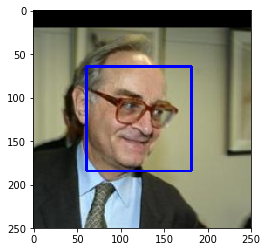

In [57]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/home/ubuntu/src/anaconda3/pkgs/opencv-3.1.0-np111py34_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')

# load color (BGR) image
img = cv2.imread(human_files[4000])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [58]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [59]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
predicted_human_h = [face_detector(img_human) for img_human in human_files_short]
print("percentage of detected human face in the human files = {}%".format(sum(predicted_human_h)))

predicted_human_d = [face_detector(img_human) for img_human in dog_files_short] 
print("percentage of detected human face in the dog files = {}%".format(sum(predicted_human_d)))

percentage of detected human face in the human files = 100%
percentage of detected human face in the dog files = 58%


In [60]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [61]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [62]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [63]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [64]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
predicted_dog_h = [dog_detector(img_dog) for img_dog in human_files_short]
print("percentage of detected dog images in the human files = {}%".format(sum(predicted_dog_h)))

predicted_dog_d = [dog_detector(img_dog) for img_dog in dog_files_short] 
print("percentage of detected dog images in the dog files = {}%".format(sum(predicted_dog_d)))

percentage of detected dog images in the human files = 2%
percentage of detected dog images in the dog files = 100%


In [65]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 140.68it/s]


In [66]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_947 (Conv2D)          (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_948 (Conv2D)          (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_949 (Conv2D)          (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50176)             0         
__________

In [67]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 367s - loss: 4.8083 - acc: 0.0234 - val_loss: 4.4689 - val_acc: 0.0443
Epoch 2/10
6680/6680 [==============================] - 367s - loss: 4.2295 - acc: 0.0735 - val_loss: 4.1769 - val_acc: 0.0731
Epoch 3/10
6680/6680 [==============================] - 404s - loss: 3.5199 - acc: 0.1931 - val_loss: 4.1711 - val_acc: 0.1078
Epoch 4/10
6680/6680 [==============================] - 403s - loss: 2.1301 - acc: 0.4744 - val_loss: 4.7242 - val_acc: 0.0934
Epoch 5/10
6680/6680 [==============================] - 402s - loss: 0.8789 - acc: 0.7784 - val_loss: 6.2029 - val_acc: 0.0862
Epoch 6/10
6680/6680 [==============================] - 402s - loss: 0.3589 - acc: 0.9100 - val_loss: 7.3752 - val_acc: 0.0862
Epoch 7/10
6680/6680 [==============================] - 402s - loss: 0.2039 - acc: 0.9451 - val_loss: 7.4900 - val_acc: 0.0862
Epoch 8/10
6680/6680 [==============================] - 402s - l

In [69]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.6555%


In [70]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [71]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


In [72]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [73]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 7s - loss: 12.0001 - acc: 0.1287 - val_loss: 10.2601 - val_acc: 0.2240
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.6583 - acc: 0.2945 - val_loss: 9.7218 - val_acc: 0.2874
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.1554 - acc: 0.3593 - val_loss: 9.5021 - val_acc: 0.3246
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 8.8964 - acc: 0.3958 - val_loss: 9.2431 - val_acc: 0.3437
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.6867 - acc: 0.4171 - val_loss: 9.0602 - val_acc: 0.3677
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.4146 - acc: 0.4407 - val_loss: 8.8191 - val_acc: 0.3868
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.2150 - acc: 0.4600 - val_loss: 8.7845 - val_acc: 0.3808
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.0796 - 

In [74]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [75]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.3349%


In [76]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [77]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
from extract_bottleneck_features import *
import numpy as np
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']

In [78]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
### TODO: Define your architecture.
model_inception = Sequential()
model_inception.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
model_inception.add(Dense(133, activation="softmax"))


model_inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


In [79]:
### TODO: Compile the model.
model_inception.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [80]:
print(train_inception.shape)

(6680, 5, 5, 2048)


Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 8s - loss: 1.1460 - acc: 0.7051 - val_loss: 0.6476 - val_acc: 0.8168
Epoch 2/25
6680/6680 [==============================] - 2s - loss: 0.4737 - acc: 0.8572 - val_loss: 0.5887 - val_acc: 0.8371
Epoch 3/25
6680/6680 [==============================] - 2s - loss: 0.3617 - acc: 0.8876 - val_loss: 0.6521 - val_acc: 0.8359
Epoch 4/25
6680/6680 [==============================] - 2s - loss: 0.2979 - acc: 0.9079 - val_loss: 0.6926 - val_acc: 0.8371
Epoch 5/25
6680/6680 [==============================] - 2s - loss: 0.2419 - acc: 0.9266 - val_loss: 0.6936 - val_acc: 0.8371
Epoch 6/25
6680/6680 [==============================] - 2s - loss: 0.2003 - acc: 0.9370 - val_loss: 0.7742 - val_acc: 0.8431
Epoch 7/25
6680/6680 [==============================] - 2s - loss: 0.1672 - acc: 0.9488 - val_loss: 0.7392 - val_acc: 0.8455
Epoch 8/25
6680/6680 [==============================] - 2s - loss: 0.1455 - ac

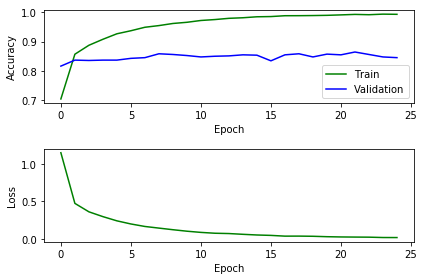

In [81]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/dog-classifier.weights.best.inception3.hdf5', 
                               verbose=1, save_best_only=True)

history = model_inception.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          epochs=25, batch_size=20, callbacks=[checkpointer], verbose=1)

import matplotlib.pyplot as plt
plt.subplot(211)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"], color="g", label="Train")

plt.tight_layout()
plt.show()

In [82]:
### TODO: Load the model weights with the best validation loss.
model_inception.load_weights('saved_models/dog-classifier.weights.best.inception3.hdf5')

In [83]:
### TODO: Calculate classification accuracy on the test dataset.
inception_predictions = [np.argmax(model_inception.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.3397%


In [84]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def inception_predict_breed(img_path):
    bottleneck_features = extract_InceptionV3(path_to_tensor(img_path))
    index = np.argmax(model_inception.predict(bottleneck_features))
    return dog_names[index]

In [85]:
img_path='images/Golden-Retriever-3-645mk062411.jpg'
inception_predict_breed(img_path)

'Golden_retriever'

In [86]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def breed_detector(img_path):
    if dog_detector(img_path) == True and face_detector(img_path) == False:
        print("it is a dog!")
        print("the dog breed is ...")
        return inception_predict_breed(img_path)
    if dog_detector(img_path) == False and face_detector(img_path) == True:
        print("it is a human!")
        print("the human looks like a ...")
        return inception_predict_breed(img_path)
    else:
        print("it is neither dog nor human!")

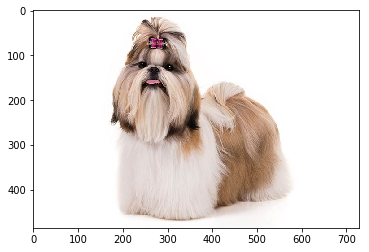

Shih-Tzu-On-White-01.jpg
it is a dog!
the dog breed is ...
Lhasa_apso


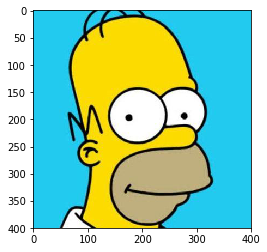

homer-simpson.jpg
it is neither dog nor human!
None


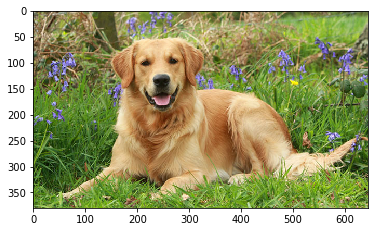

Golden-Retriever-3-645mk062411.jpg
it is a dog!
the dog breed is ...
Golden_retriever


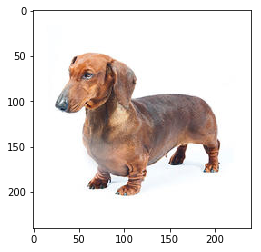

Dachshund.jpg
it is a dog!
the dog breed is ...
Dachshund


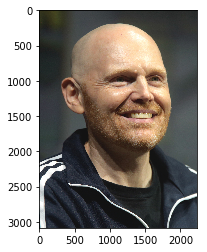

Bill_Burr.jpg
it is a human!
the human looks like a ...
Dachshund


In [87]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
from os import listdir
from os.path import join
images_path= 'myimages/'
imageNames = listdir(images_path)
for imagename in imageNames:
    if imagename.endswith(".jpg"): 
        img = cv2.imread(join(images_path,imagename))
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print(imagename)
        print(breed_detector(join(images_path,imagename)))
        